In [15]:
import numpy as np
import random
import pandas as pd
import math
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gdp
from itertools import combinations
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
import geopandas as gpd
from geopandas.geoseries import Point

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# HELPERS

In [2]:
def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 

    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())


def getBinnedDistribution(x, y, nbins):

    n, bins = np.histogram(x, bins=nbins)
    sy, _   = np.histogram(x, bins=nbins, weights=y)
    mean    = sy/n

    return _, mean

# FEATURES

In [3]:
features = pd.read_csv('senior_venues_features_labels.csv', sep = '\t', index_col = 0)

user_nw   = [u for u in features.keys() if 'WHO_u' in u]
user_succ = [u for u in features.keys() if 'tipCount' in u or 'checkinsCount' in u or 'usersCount' in u or 'Llikecount' in u or 'lLondon' in u]
features  = features.drop(columns = user_nw + user_succ)
features  = features.drop(columns = [c for c in features.keys() if '_inv_' in c])
features  = features.drop(columns = [c for c in features.keys() if '_grav_' in c])
features  = features.dropna()

features  = features.drop(columns = ['WHO_v_social_stretch', 'WHO_v_social_std'])
features2 = features

firstimes = pd.read_csv('venues_firstime.csv', sep = '\t', header = None, index_col = 0)
firstimes.index.name = 'venue'
firstimes = firstimes.rename(columns = {1: 'WHEN_firsttime', 2 :'WHEN_hour_most', 3 : 'WHEN_day_most'})
firstimes = firstimes.drop(columns = [4])

genders = pd.read_csv('venues_genders.csv', sep = '\t',  index_col = 0)
genders = genders.rename(columns = {'female': 'WHO_female_fraction'})
genders = genders.drop(columns = ['LABEL_category'])

genders.head()

features2 = features2.join(firstimes)
features2 = features2.join(genders)

print len(features2.keys()), len(features2)
features2.head()
features2.head()
firstimes.head()




venues_clussified = set(features2.index)


city        = 'london'
outfolder   = '../../ProcessedData/' + city + '/'
successdata = outfolder + 'venues_info/' + city + '_venues_success_measures.csv'
success     = pd.read_csv(successdata, sep = '\t', index_col = 0)
success     = success[~success.index.duplicated(keep='first')]   
success['quartile'] = pd.qcut(success['checkinsCount'], 4, ['q1','q2','q3','q4'])
Q1 = set(list(success[success['quartile'] == 'q1'].index))
Q2 = set(list(success[success['quartile'] == 'q2'].index))
Q3 = set(list(success[success['quartile'] == 'q3'].index))
Q4 = set(list(success[success['quartile'] == 'q4'].index))



print len(venues_clussified)
print len(Q1)
print len(Q4)

print round(len(venues_clussified.intersection(Q1))/float(len(venues_clussified)), 2)
print round(len(venues_clussified.intersection(Q2))/float(len(venues_clussified)), 2)
print round(len(venues_clussified.intersection(Q3))/float(len(venues_clussified)), 2)
print round(len(venues_clussified.intersection(Q4))/float(len(venues_clussified)), 2)

109 8183
8183
25763
25239
0.0
0.0
0.04
0.96


# BALANCE SAMPLES

In [4]:
outfolder  = 'Figures/datafiles/'
files      = [outfolder + f for f in os.listdir(outfolder) if 'clusters_data_all_' in f]
indicies   = [(i,j) for i in range(2) for j in range(3)]
clusters   = [fn.split('_')[3].replace('.dat', '') for fn in files] 
N          = 160

clusters_venues = {}
for cluster in clusters:
    clusters_venues[cluster] = []
    for ind, line in enumerate(open(outfolder + '/sorted_dist/sorted_dist_venues_in_' + cluster + '.dat')):
        if ind == N: break
        clusters_venues[cluster].append(line.strip().split('\t')[0])


top100venues = []
for c, vens in clusters_venues.items():
    
    top100venues += vens
    

print clusters_venues.keys()
features3 = features2[features2.index.isin(top100venues)]    
print len(features), len(features2), len(features3.keys()), len(features3)

features3 = features3.dropna()
features2.to_csv('FINAL_FEATURES_UNCORR_BALANCED_ALL.csv', '\t')
features3.to_csv('FINAL_FEATURES_UNCORR_BALANCED_160.csv', '\t')

features3.head()


pd.DataFrame(features3.drop_duplicates(subset=['LABEL_category'], keep='last').LABEL_category)



clustersids =  {3: 'rise',
                2: 'fallandrise ',
                0: 'ephemeral',
                1: 'fall',
                4: 'riseandfall',
                5: 'underdogs'}


X = features3.drop(columns = ['LABEL_category'])
y = np.asarray(features3.LABEL_category)

['fallandrise', 'rise', 'ephemeral', 'riseandfall', 'fall', 'underdogs']
8183 8183 109 960


# FEATURE SELECTION

# First use the feature selection algo to pic those which rel importance is above 2%, 10 features per group a top

In [5]:
'''def xgb_get_top_10_features(X, y, max_depth_ ,learning_rate_, subsample_, tipus = ''):
              
    X_ = X.drop(columns = [c for c in X.keys() if tipus not in c] )  
     http://localhost:8888/notebooks/FINAL_PREDICTIONS.ipynb#  
    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
          
    featurenames, importances = zip(*sorted(zip(train_data.keys(), model2.feature_importances_), key=lambda tup: tup[1], reverse = True))
    featurenames, importances = zip(*[(featurenames[i], importances[i]) for i in range(len(featurenames)) if importances[i] > 0.02])

    if len(featurenames) > 9:
       featurenames, importances = zip(*sorted(zip(train_data.keys(), model2.feature_importances_), key=lambda tup: tup[1], reverse = True)[0:10])
 
    
    print tipus, len(featurenames)
    
    return featurenames, importances
 

depth  = 6
rate   = 0.01
sample = 0.8
    
    
featurenames_all,   importances_all   = xgb_get_top_10_features(X, y, depth, rate, sample, '')  
featurenames_where, importances_where = xgb_get_top_10_features(X, y, depth, rate, sample, 'WHERE')  
featurenames_who,   importances_who   = xgb_get_top_10_features(X, y, depth, rate, sample, 'WHO')  
featurenames_when,  importances_when  = xgb_get_top_10_features(X, y, depth, rate, sample, 'WHEN')  
featurenames_what,  importances_what  = xgb_get_top_10_features(X, y, depth, rate, sample, 'WHAT')
'''
print ''

#### Feature selection algo  

In [6]:
'''def xgb_get_given_features(X, y, features, max_depth_ ,learning_rate_, subsample_, tipus = ''):
     
    X_ = X.drop(columns = [c for c in X.keys() if c not in list(features)] )  
      
    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    accuracies   = list(cross_val_score(train_model2, train_data, train_label, cv=5))

    return np.mean(accuracies), np.std(accuracies)
  

def get_accuracy_ts(featurenames_type, tipus):
    
    f, ax = plt.subplots(1,1, figsize = (10,4))

    
    accurate_features = {}
    folderout         = 'Featureselection'

    if not os.path.exists(folderout): os.makedirs(folderout)
    
    nnn = len(featurenames_type)
    
    
    for i in range(1,len(featurenames_type)+1):

        print tipus, '\t', i, '/', nnn
        
        feats = list(combinations(featurenames_type, i))
        maxA  = 0
        maxR  = 0  
        
        for feat in feats:

            acc, accerr = xgb_get_given_features(X, y, feat, depth ,rate, sample, tipus = '')

            if acc > maxA:
                maxA = acc
                maxR = (acc, accerr, feat)
            
        accurate_features[i] = maxR
        
        
    ax.errorbar(accurate_features.keys(), [i[0] for i in accurate_features.values()], yerr =  [i[1] for i in accurate_features.values()])    
    ax.set_title(tipus, fontsize = 15)
    ax.set_ylabel('accuracy', fontsize = 11)
    ax.set_xlabel('best N features', fontsize = 11)
    plt.savefig(folderout + '/features_combinations_' + tipus + '.png')
    
    fout = open(folderout + '/features_combinations_' + tipus + '.dat', 'w')
    fout.write('Number of features\tAccuracy\tAccError\tFeatures\n')
    for i, feats in accurate_features.items():
        fout.write(str(i) + '\t' + str(feats[0]) + '\t' + str(feats[1]) + '\t' + '\t'.join(feats[2]) + '\n')
    fout.close()
        
      
 
get_accuracy_ts(featurenames_who, 'who')
get_accuracy_ts(featurenames_where, 'where')

get_accuracy_ts(featurenames_when, 'when')
get_accuracy_ts(featurenames_what, 'what')

get_accuracy_ts(featurenames_all, 'all')

'''  
print ''

In [7]:
features_most_pred = ['WHEN_firsttime', 
                      'WHEN_hour_most',
                      'WHAT_venue_cat', 
                      'WHAT_pricerange',
                    'WHEN_firsttime',
                    'WHO_m_entropy',
                    'WHERE_emb_own_cat',
                    'WHO_fraction_of_regulars',
                    'WHERE_emb_na',
                    'WHO_m_std',
                    'WHO_m_avg',
                    'WHERE_emb_own_cat',
                    'WHERE_emb_na',
                    'WHERE_distance_from_center',
                    'WHERE_emb_building',
                    'WHERE_emb_travel',
                    'WHERE_emb_event',
                    'WHO_m_entropy',
                    'WHO_female_fraction',
                    'WHO_fraction_of_regulars',
                    'WHO_m_std',
                    'WHO_m_3_fraction',
                    'WHO_m_avg']

features_most_pred = list(set(features_most_pred))

10 ['WHO_fraction_of_regulars', 'WHEN_hour_most', 'WHERE_distance_from_center', 'WHEN_firsttime', 'WHAT_pricerange', 'WHO_m_entropy', 'WHAT_venue_cat', 'WHERE_emb_own_cat', 'WHO_female_fraction', 'WHERE_emb_building']


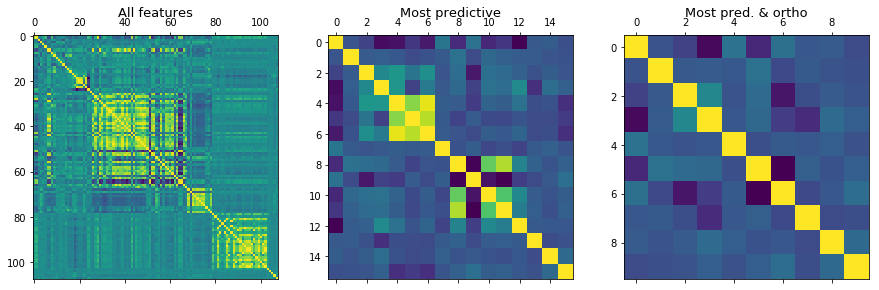

In [8]:
f, ax = plt.subplots(1,3, figsize = (15,4.5))

ax[0].matshow(X.corr())
X_pred = X.drop(columns = [c for c in X.keys() if c not in features_most_pred])
ax[1].matshow(X_pred.corr())


redundant_features = ['WHERE_emb_na', 'WHO_m_3_fraction', 'WHO_m_avg', 'WHO_m_std','WHERE_emb_event', 'WHERE_emb_travel']
X
features_most_pred_uncorr = [f for f in features_most_pred if f not in redundant_features]
X_pred_uncorr = X.drop(columns = [c for c in X.keys() if c not in features_most_pred_uncorr])
ax[2].matshow(X_pred_uncorr.corr())

ax[0].set_title('All features',       fontsize = 13)
ax[1].set_title('Most predictive',    fontsize = 13)
ax[2].set_title('Most pred. & ortho', fontsize = 13)

print len(features_most_pred_uncorr), features_most_pred_uncorr

plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/correlations.png')

# Renaming features - REQUEST 1

In [9]:
network_users = pd.DataFrame.from_csv('FINAL_DATA/london_COMBINED_networkmeasures_2000.csv')
network_users = network_users.drop(columns = [c for c in network_users.keys() if c != 'u_pagerank_avg'])
network_users.head()


,u_pagerank_avg
4a5f9446f964a520e0bf1fe3,1.539840e-06
4abcec53f964a520b98720e3,3.379230e-06
4abdc1c7f964a5206d8b20e3,6.256018e-07
4abe4502f964a520558c20e3,6.512054e-08
4abe5714f964a520d68c20e3,1.049486e-06


In [10]:
category_distances = pd.DataFrame.from_csv('../../ProcessedData/london/venues_info/CATEGORY_embeddedness.dat', sep = '\t')
print len(category_distances)
category_distances = category_distances[category_distances.index.isin(X_pred_uncorr.index)]
print len(category_distances)
category_distances.head()
print y[0:10]

101177
923
[3 2 3 0 5 3 4 0 0 0]


In [12]:
X_pred_uncorr_renamed = pd.DataFrame()


X_pred_uncorr_renamed['WHERE - Bohemian score']         = X['WHERE_ArtsEmploy']
X_pred_uncorr_renamed['WHERE - IMD score']              = X['WHERE_IMDScore']
X_pred_uncorr_renamed['WHERE - Population density']     = X['WHERE_PopDen']
#X_pred_uncorr_renamed['WHERE - Central neighbourhood']  =  X_pred_uncorr['WHERE_distance_from_center'].apply(rec)

X_pred_uncorr_renamed['WHERE - Residential neighbourhood']   = category_distances['building']
#X_pred_uncorr_renamed['WHERE - Residential neighbourhood_2'] = X_pred_uncorr['WHERE_emb_building']

X_pred_uncorr_renamed['WHAT - Unique in neighbourhood']    = category_distances['own_cat']
#X_pred_ncorr_renamed['WHAT - Unique in neighbourhood_2']  = X_pred_uncorr['WHERE_emb_own_cat']
X_pred_uncorr_renamed['WHAT - Venue category']             = X_pred_uncorr['WHEN_firsttime']
X_pred_uncorr_renamed['WHAT - Price category']             = X_pred_uncorr['WHEN_hour_most']

#X_pred_uncorr_renamed['WHEN - Time of the first occurance']    = X_pred_uncorr['WHEN_firsttime']
#X_pred_uncorr_renamed['WHEN - Most popular hour of the day']   = X_pred_uncorr['WHEN_hour_most']
X_pred_uncorr_renamed['WHO - Regulars score']                  = X_pred_uncorr['WHO_fraction_of_regulars']
X_pred_uncorr_renamed['WHO - Diversity in purchasing power']   = X_pred_uncorr['WHO_m_entropy']


#X_pred_uncorr_renamed = X_pred_uncorr_renamed.drop(columns = [ 'WHEN - Most popular hour of the day'])

aa = pd.read_csv('venues_genders.csv', sep = '\t', index_col = 0)
aa = aa.rename(columns = {'female' : 'WHO - Gender balance score'})

X_pred_uncorr_renamed = X_pred_uncorr_renamed.merge(network_users, right_index = True, left_index = True)
X_pred_uncorr_renamed = X_pred_uncorr_renamed.merge(aa, right_index = True, left_index = True)
X_pred_uncorr_renamed = X_pred_uncorr_renamed.rename(columns = {'LABEL_category' : 'Cluster'})
X_pred_uncorr_renamed = X_pred_uncorr_renamed.rename(columns = {'u_pagerank_avg' : 'WHO - Average Pagerank of customers from Contact Network' })

X_pred_uncorr_renamed_Labeled = X_pred_uncorr_renamed
X_pred_uncorr_renamed = X_pred_uncorr_renamed.drop(columns = ['Cluster'])

X_pred_uncorr_renamed.head()

,WHERE - Bohemian score,WHERE - IMD score,WHERE - Population density,WHERE - Residential neighbourhood,WHAT - Unique in neighbourhood,WHAT - Venue category,WHAT - Price category,WHO - Regulars score,WHO - Diversity in purchasing power,WHO - Average Pagerank of customers from Contact Network,WHO - Gender balance score
4ac51183f964a52049a020e3,700.0,22.33,14285.7,0.569905,1.367268,1.339332e+09,17,0.216110,0.992990,9.940441e-08,0.147287
4ac518b4f964a52067a020e3,8200.0,24.73,3085.7,0.401649,1.004700,1.360076e+09,0,0.100000,0.989458,7.536223e-06,-0.200000
4ac518b4f964a52072a020e3,4600.0,20.48,5300.0,0.321283,1.190251,1.339444e+09,19,0.160000,0.991121,4.362998e-07,0.207143
4ac518b4f964a52073a020e3,700.0,11.65,2583.3,0.381227,1.356662,1.346148e+09,2,0.200000,0.989679,4.321611e-06,0.263158
4ac518b4f964a5207aa020e3,200.0,31.54,10384.6,0.606283,1.177433,1.372147e+09,0,0.071429,0.987350,4.836148e-06,0.307692


# CORRELATIONS - REQUEST 2

In [21]:
distances = pd.read_csv('distance_correlation.csv', sep = '\t', index_col = 0)
distances_filtered = distances[distances.index.isin(list(X_pred_uncorr_renamed.index))]

In [23]:
corr  = np.zeros((len(X_pred_uncorr_renamed.keys()), len(distances_filtered.keys())))
pval  = np.zeros((len(X_pred_uncorr_renamed.keys()), len(distances_filtered.keys())))
cls   = []
feats = []

for ind, cl in enumerate(distances_filtered.keys()):

    cls.append(cl)
    
    for jind, feat in enumerate(X_pred_uncorr_renamed.keys()):

        feats.append(feat)
  
        d1 = dict(distances_filtered[cl])
        d2 = dict(X_pred_uncorr_renamed[feat])
        
        xxx, yyy = zip(*[(dist, d2[ven]) for ven, dist in d1.items()])
        
        C = stats.spearmanr(xxx,yyy)
          
        corr[jind, ind] = C[0]
        pval[jind, ind] = C[1]

NameError: name 'feats' is not defined

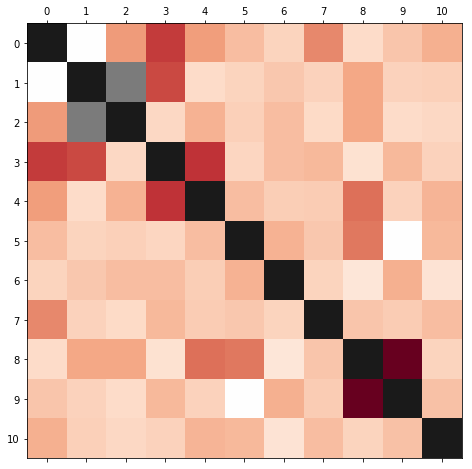

In [14]:
f, ax = plt.subplots(1,1,figsize=(15,8))
im1 = ax.matshow(X_pred_uncorr_renamed.corr(), cmap=plt.get_cmap('RdGy'))


ax.set_xticks(np.arange(len(X_pred_uncorr_renamed.keys())))
ax.set_yticks(np.arange(len(X_pred_uncorr_renamed.keys())))  
ax.set_xticklabels(feats[0:len(X_pred_uncorr_renamed.keys())], rotation = 90, ha = 'center', fontsize = 15)
ax.set_yticklabels(feats[0:len(X_pred_uncorr_renamed.keys())], fontsize = 15)


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='vertical')


plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/Featured_cross_correlation.png', bbox_inches="tight")

NameError: name 'distances_filtered' is not defined

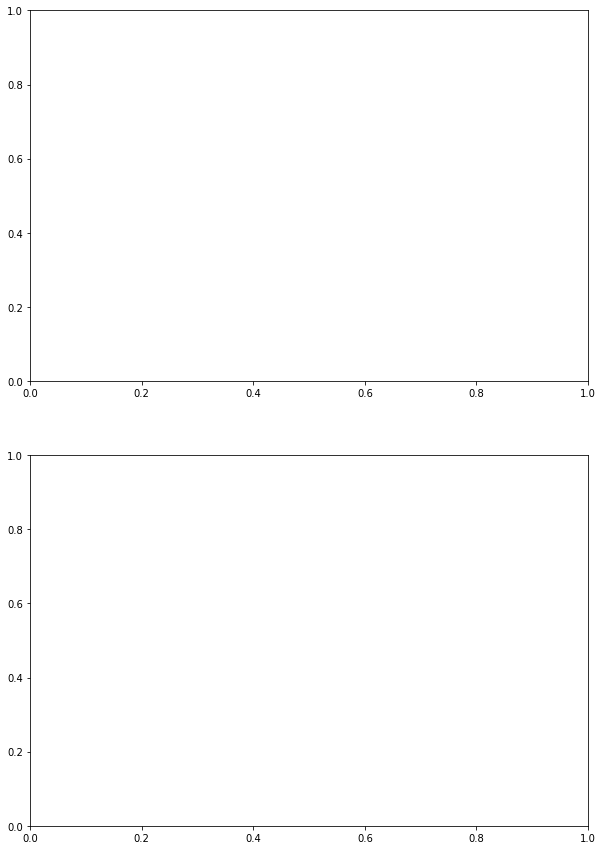

In [16]:
f, ax = plt.subplots(2,1, figsize = (10,15))


for i in range(2):
    ax[i].set_xticks(np.arange(len(distances_filtered.keys())))
    ax[i].set_yticks(np.arange(len(X_pred_uncorr_renamed.keys())))  
    ax[i].set_xticklabels(cls[0:len(distances_filtered.keys())], rotation = 90, ha = 'center', fontsize = 15)
    ax[i].set_yticklabels(feats[0:len(X_pred_uncorr_renamed.keys())], fontsize = 15)

im1 = ax[0].imshow(corr, cmap=plt.get_cmap('RdGy'))
im2 = ax[1].imshow(pval, cmap=plt.get_cmap('Reds'))

print corr


ax[0].set_title('$c_{\\rm spearmanr}$', fontsize = 22)
ax[1].set_title('$p$ value', fontsize = 22)


divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1])
dax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im2, cax=dax, orientation='vertical');


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.3, hspace=2.5)
plt.tight_layout()
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/Distance_feature_correlation.png', bbox_inches="tight")

# 6 SHAPES SLECTED FEATURES

In [81]:
venues_clussified = set(XNEW.index)


city        = 'london'
outfolder   = '../../ProcessedData/' + city + '/'
successdata = outfolder + 'venues_info/' + city + '_venues_success_measures.csv'
success     = pd.read_csv(successdata, sep = '\t', index_col = 0)
success     = success[~success.index.duplicated(keep='first')]   
success['quartile'] = pd.qcut(success['checkinsCount'], 4, ['q1','q2','q3','q4'])
Q1 = set(list(success[success['quartile'] == 'q1'].index))
Q2 = set(list(success[success['quartile'] == 'q2'].index))
Q3 = set(list(success[success['quartile'] == 'q3'].index))
Q4 = set(list(success[success['quartile'] == 'q4'].index))


print len(venues_clussified)
print len(Q1)
print len(Q4)

print round(len(venues_clussified.intersection(Q1))/float(len(venues_clussified)), 2)
print round(len(venues_clussified.intersection(Q2))/float(len(venues_clussified)), 2)
print round(len(venues_clussified.intersection(Q3))/float(len(venues_clussified)), 2)
print round(len(venues_clussified.intersection(Q4))/float(len(venues_clussified)), 2)


923
25763
25239
0.0
0.0
0.06
0.94


0.32370879960465826 6 0.01 0.9
0.32370879960465826
0.2312090940157602 4 0.15 0.95
0.2312090940157602
0.2849946995680491 6 0.05 0.85
0.2849946995680491
0.20714292939098028 5 0.2 0.9
0.20714292939098028


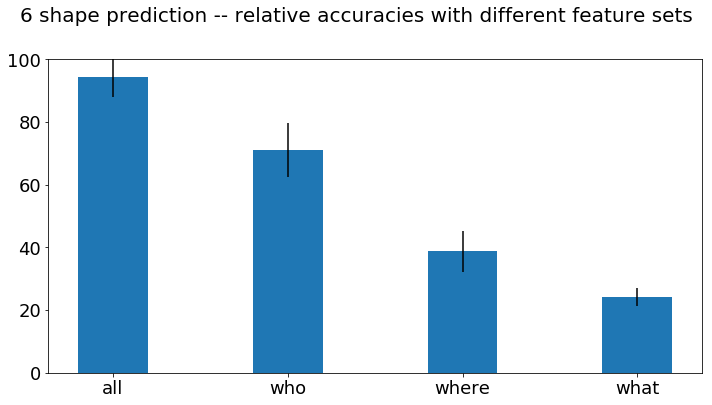

In [56]:
XNEW = X_pred_uncorr_renamed_Labeled.drop(columns = ['Cluster'])
yNEW = np.asarray(X_pred_uncorr_renamed_Labeled.Cluster)



def xgb_model_params_types_given_features(X, y, tipus = ''):
      
        
     
    acc, depth, rate, sample = [line.replace(',','').strip().split('\t') for line in open('FINAL_OPT_RES/' + tipus + '_best.dat' )][0]
       
    print acc, depth, rate, sample    
        
    max_depth_     = int(float(depth))
    learning_rate_ = float(rate)
    subsample_     = float(sample)

    
        
    X_ = X.drop(columns = [c for c in X.keys() if tipus not in c])  
     
    #print X_.keys()
        
    #print len(X_.keys())
    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
            
    accuracies = list(cross_val_score(train_model2, train_data, train_label, cv=5))       
    print  np.mean(accuracies)   
      
        
    return np.mean(accuracies), np.std(accuracies)
     
    
depth  = 6
rate   = 0.02
sample = 0.95
                           
All,    Aerrall   = xgb_model_params_types_given_features(XNEW, yNEW, tipus = '' )
Awhat,  Aerrwhat  = xgb_model_params_types_given_features(XNEW, yNEW, tipus = 'WHAT' )
Awho,   Aerrwho   = xgb_model_params_types_given_features(XNEW, yNEW, tipus = 'WHO'  )
Awhere, Aerrwhere = xgb_model_params_types_given_features(XNEW, yNEW, tipus = 'WHERE')



f, ax = plt.subplots(1,1,figsize=(10,6))

names    = ['all', 'where', 'who',  'what']
results  = [All,      Awhat,    Awho,    Awhere]
errors   = [Aerrall,  Aerrwhat, Aerrwho, Aerrwhere]

results2 = [100*r / (1.0/6.0) - 100 for r in results]
errors2  = [results2[i] * errors[i]/results[i]  for i in range(len(results)) ]


ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize = 18)


names, results2, errors2 = zip(*sorted([(names[i], results2[i], errors2[i]) for i in range(len(names))] , key=lambda tup: tup[1], reverse = True))

#ax.set_title('All features', fontsize = 20)
ax.set_xticklabels(names, fontsize = 18)

ax.bar(names, results2, yerr = errors2, width = 0.4)
ax.set_ylim(0,100)

plt.tight_layout( rect=[0, 0.05, 1, 0.9])
plt.suptitle('6 shape prediction -- relative accuracies with different feature sets', fontsize = 20)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/6shapespred1.png')



WHERE - Bohemian score 22.515575405211365 22.515575405211365
WHERE - IMD score 27.396698859398256 27.396698859398256
WHERE - Population density 24.517841312777307 24.517841312777307
WHERE - Residential neighbourhood 15.55133729727821 15.55133729727821
WHAT - Unique in neighbourhood 19.656512812224136 19.656512812224136
WHAT - Venue category 56.97313391612798 56.97313391612798
WHAT - Price category 14.685143195264075 14.685143195264075
WHO - Regulars score -6.798626831528637 0
WHO - Diversity in purchasing power 61.125937458102555 61.125937458102555
WHO - Average Pagerank of customers from Contact Network 68.86343897144266 68.86343897144266
WHO - Gender balance score 26.227189590325253 26.227189590325253


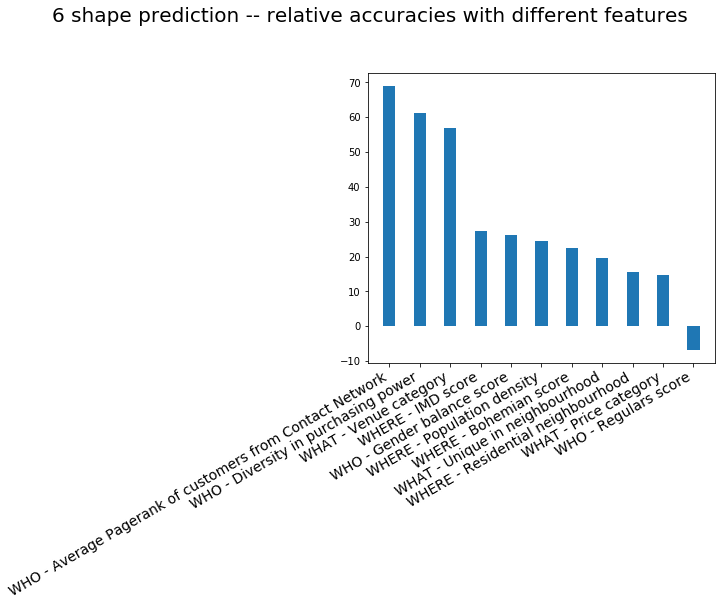

In [70]:
XNEW = X_pred_uncorr_renamed_Labeled.drop(columns = ['Cluster'])
yNEW = np.asarray(X_pred_uncorr_renamed_Labeled.Cluster)



def xgb_model_params_types_given_feature(X, y, NAMEDFEAT):
              
    X_ = X.drop(columns = [c for c in X.keys() if c != NAMEDFEAT])  
     

    acc, depth, rate, sample = [line.replace(',','').strip().split('\t') for line in open('FINAL_OPT_RES/' + NAMEDFEAT + '_best.dat' )][0]
       
   # print acc, depth, rate, sample    
        
    max_depth_     = int(float(depth))
    learning_rate_ = float(rate)
    subsample_     = float(sample)
        
        
    
    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
            
    accuracies = list(cross_val_score(train_model2, train_data, train_label, cv=5))     
    
    
    relacc = 100*np.mean(accuracies)  / (1.0/6.0) - 100 
    relerr = 100*np.std(accuracies) / (1.0/6.0) - 100 
    
    print  NAMEDFEAT, relacc, acc
        
    return relacc, relerr#(np.mean(accuracies), np.std(accuracies))
     
    
depth  = 5
rate   = 0.2
sample = 0.75
   
names   = []
results = []
errors  = []
    
    
    
for NAMEDFEAT in XNEW.keys() :

    acc, err = xgb_model_params_types_given_feature(XNEW, yNEW,  NAMEDFEAT )
    names.append(NAMEDFEAT)
    results.append(acc)
    errors.append(err)




f, ax = plt.subplots(1,1,figsize=(10,9))


#ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize = 18)


names, results, errors = zip(*sorted([(names[i], results[i], errors[i]) for i in range(len(names))] , key=lambda tup: tup[1], reverse = True))

ax.bar(names, results, width = 0.4)
#ax.set_ylim(0,100)
ax.set_xticklabels(names, fontsize = 14, rotation = 30, ha = 'right')

plt.tight_layout( rect=[0, 0.05, 1, 0.9])
plt.suptitle('6 shape prediction -- relative accuracies with different features', fontsize = 20)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/6shapespred2.png')





# 6 SHAPES CLASS

In [ ]:
from sklearn.model_selection import cross_val_score


def xgb_model_params_types_given_features(X, y, max_depth_ ,learning_rate_, subsample_, tipus = ''):
              
    X_ = X.drop(columns = [c for c in X.keys() if tipus not in c])  
     
    #print X_.keys()
        
    #print len(X_.keys())
    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
            
    accuracies = list(cross_val_score(train_model2, train_data, train_label, cv=5))       
    print  np.mean(accuracies)   
        
    return (np.mean(accuracies), np.std(accuracies))
     
    
depth  = 6
rate   = 0.015
sample = 0.8
                           
All,    Aerrall   = xgb_model_params_types_given_features(X, y, depth, rate, sample, tipus = '' )
Awhat,  Aerrwhat  = xgb_model_params_types_given_features(X, y, depth, rate, sample, tipus = 'WHAT' )
Awho,   Aerrwho   = xgb_model_params_types_given_features(X, y, depth, rate, sample, tipus = 'WHO'  )
Awhere, Aerrwhere = xgb_model_params_types_given_features(X, y, depth, rate, sample, tipus = 'WHERE')



In [150]:
def xgb_model_params_types_given_features(X, y,features_most_pred_uncorr,  max_depth_ ,learning_rate_, subsample_, tipus = ''):
              
    X_ = X.drop(columns = [c for c in X.keys()  if tipus not in c]) 
    X_ = X_.drop(columns = [c for c in X_.keys() if c not in features_most_pred_uncorr])
  
    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
            
    accuracies = list(cross_val_score(train_model2, train_data, train_label, cv=5))       
        
    print np.mean(accuracies)    
    return (np.mean(accuracies), np.std(accuracies))




AallS,   AerrallS   = xgb_model_params_types_given_features(X, y, features_most_pred, depth, rate, sample, tipus = '')                       
#AwhenS,  AerrwhenS  = xgb_model_params_types_given_features(X, y, features_most_pred, depth, rate, sample, tipus = 'WHEN')
AwhatS,  AerrwhatS  = xgb_model_params_types_given_features(X, y, features_most_pred, depth, rate, sample, tipus = 'WHAT')
AwhoS,   AerrwhoS   = xgb_model_params_types_given_features(X, y, features_most_pred, depth, rate, sample, tipus = 'WHO')
AwhereS, AerrwhereS = xgb_model_params_types_given_features(X, y, features_most_pred, depth, rate, sample, tipus = 'WHERE')

AallSc,   AerrallSc   = xgb_model_params_types_given_features(X, y, features_most_pred_uncorr, depth, rate, sample, tipus = '')                       
#AwhenSc,  AerrwhenSc  = xgb_model_params_types_given_features(X, y, features_most_pred_uncorr, depth, rate, sample, tipus = 'WHEN')
AwhatSc,  AerrwhatSc  = xgb_model_params_types_given_features(X, y, features_most_pred_uncorr, depth, rate, sample, tipus = 'WHAT')
AwhoSc,   AerrwhoSc   = xgb_model_params_types_given_features(X, y, features_most_pred_uncorr, depth, rate, sample, tipus = 'WHO')
AwhereSc, AerrwhereSc = xgb_model_params_types_given_features(X, y, features_most_pred_uncorr, depth, rate, sample, tipus = 'WHERE')


0.3316322203097112
0.241157516080626
0.29945455247293457
0.21044426609479183
0.29928975450397377
0.241157516080626
0.2347759683751387
0.17339679608472972


[0.3039160288963593, 0.24606374162915184, 0.280010446046495, 0.22177265311518943]


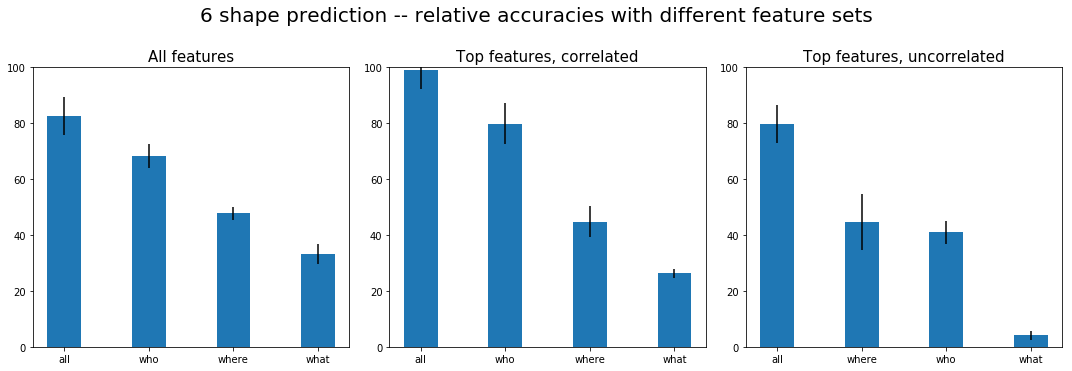

In [159]:
f, ax = plt.subplots(1,3,figsize=(15,5.5))

names    = ['all', 'where', 'who',  'what']
results  = [All,  Awhat, Awho, Awhere]
errors   = [Aerrall,  Aerrwhat, Aerrwho, Aerrwhere]

results2 = [100*r / (1.0/6.0) - 100 for r in results]
errors2  = [results2[i] * errors[i]/results[i]  for i in range(len(results)) ]


names, results2, errors2 = zip(*sorted([(names[i], results2[i], errors2[i]) for i in range(len(names))] , key=lambda tup: tup[1], reverse = True))

ax[0].set_title('All features', fontsize = 15)
ax[0].bar(names, results2, yerr = errors2, width = 0.4)
ax[0].set_ylim(0,100)





namesS    = ['all', 'where', 'who', 'what']
resultsS  = [AallS,  AwhatS, AwhoS, AwhereS]
errorsS   = [AerrallS, AerrwhatS, AerrwhoS, AerrwhereS]

print results

results2S = [100*r / (1.0/6.0) - 100 for r in resultsS]
errors2S  = [results2S[i] * errorsS[i]/resultsS[i]  for i in range(len(resultsS)) ]

namesS, results2S, errors2S = zip(*sorted([(namesS[i], results2S[i], errors2S[i]) for i in range(len(names))] , key=lambda tup: tup[1], reverse = True))

ax[1].set_title('Top features, correlated', fontsize = 15)
ax[1].bar(namesS, results2S, yerr = errors2S, width = 0.4)
ax[1].set_ylim(0,100)





#namesSc    = ['all', 'where', 'who', 'when', 'what']
#resultsSc  = [AallSc, AwhenSc, AwhatSc, AwhoSc, AwhereSc]
#errorsSc   = [AerrallSc, AerrwhenSc, AerrwhatSc, AerrwhoSc, AerrwhereSc]



namesSc    = ['all', 'where', 'who', 'what']
resultsSc  = [AallSc,  AwhatSc, AwhoSc, AwhereSc]
errorsSc   = [AerrallSc,  AerrwhatSc, AerrwhoSc, AerrwhereSc]


results2Sc = [100*r / (1.0/6.0) - 100 for r in resultsSc]
errors2Sc  = [results2S[i] * errorsS[i]/resultsS[i]  for i in range(len(resultsSc)) ]

namesSc, results2Sc, errors2Sc = zip(*sorted([(namesSc[i], results2Sc[i], errors2Sc[i]) for i in range(len(names))] , key=lambda tup: tup[1], reverse = True))

ax[2].set_title('Top features, uncorrelated', fontsize = 15)
ax[2].bar(namesSc, results2Sc, yerr = errors2Sc, width = 0.4)
ax[2].set_ylim(0,100)
plt.tight_layout( rect=[0, 0.05, 1, 0.9])

plt.suptitle('6 shape prediction -- relative accuracies with different feature sets', fontsize = 20)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/6shapespred1.png')

('all', 'who', 'where', 'what')


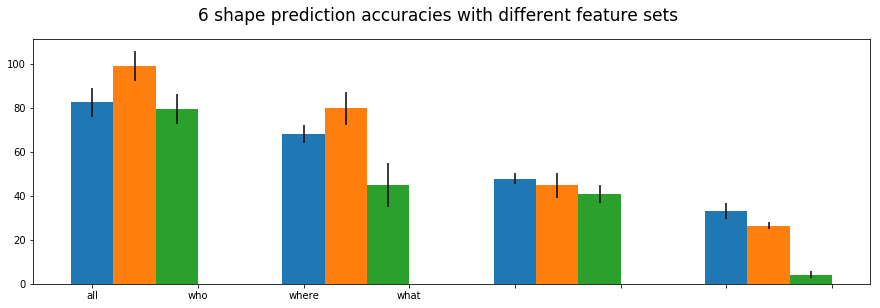

In [153]:
f, ax = plt.subplots(1,1,figsize=(15,4.5))

ax.bar(np.arange(len(names)),      results2,   yerr = errors2,   width = 0.2, label = 'all features')
ax.bar(np.arange(len(names))+0.2,  results2S,  yerr = errors2S,  width = 0.2, label = 'top predictive, correlated')
ax.bar(np.arange(len(names))+0.4,  results2Sc, yerr = errors2Sc, width = 0.2, label = 'top predictive, uncorrelated')
ax.legend(loc = 'best')

#ax.bar(namesSc+0.8, results2Sc, yerr = errors2Sc, width = 0.4)
ax.set_xticklabels(np.arange(len(names))+0.2)
ax.set_xticklabels([''] + list(names))
plt.suptitle('6 shape prediction accuracies with different feature sets', fontsize = 17)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/6shapespred2.png')
print names




In [120]:
for i in range(5):
    print results2S[i], errors2S[i]

90.07288184242626 13.207712080273211
77.73876172703152 7.057721394318692
48.427244024125514 5.01547708457545
45.7590062704146 3.9341230780048098
39.95851822402142 5.280032341020652


# BINARY CLASS

In [85]:
city        = 'london'
datafile    = 'FINAL_DATA'
successdata = datafile + '/london_venues_success_measures.csv'
venues      = [line.strip() for line in open(datafile + '/senior_venues_lists.dat')]

success  = pd.read_csv(successdata, sep = '\t', index_col = 0)
success  = success[~success.index.duplicated(keep='first')]   
success  = success[success.index.isin(venues)]

successdata_L = datafile + '/london_venues_success_measures_local_like.csv'
success_L     = pd.read_csv(successdata_L, sep = '\t', index_col = 0)
success_L     = success_L[~success_L.index.duplicated(keep='first')]   
success       = success.join(success_L)

success.index.name = 'venue'

success.head()   

,tipCount,checkinsCount,usersCount,Llikecount
venue,,,,
4a5f9446f964a520e0bf1fe3,75.0,2500.0,1831.0,33.195062
4abcec53f964a520b98720e3,17.0,1550.0,913.0,16.468388
4abdc1c7f964a5206d8b20e3,47.0,5573.0,2777.0,91.575568
4abe4502f964a520558c20e3,575.0,97190.0,80793.0,445.616354
4abe5714f964a520d68c20e3,54.0,1507.0,1256.0,49.789535


In [86]:
def get_success_Qs(segments, success, measure, randomized = False):

    if randomized: 
        np.random.shuffle(success[measure])
        
    labels = ['q' + str(i+1) for i in range(segments)]    
        
    success['quartile'] = pd.qcut(success[measure], segments, labels)
    Q1 = list(success[success['quartile'] == labels[0]].index)
    Q4 = list(success[success['quartile'] == labels[-1]].index)

    
    return Q4, Q1, success

VenuesTop, VenuesBottom, success = get_success_Qs(4, success, 'Llikecount', randomized = False)



In [87]:
features_VenuesTop    = features3[features3.index.isin(VenuesTop)]
features_VenuesBottom = features3[features3.index.isin(VenuesBottom)]

features_VenuesTop['success']    = 1
features_VenuesBottom['success'] = 0

X = features_VenuesTop.append(features_VenuesBottom)
y = np.asarray(X.success)
X = X.drop(columns = ['success'])

X = X.round(3)


In [92]:
def classifiers_types(X, y, tipus = '', randomize = False):
   
    X_ = X.drop(columns = [c for c in X.keys() if tipus not in c])

    print len(X_.keys())
    classifier = RandomForestClassifier(max_depth=5, n_estimators=100, max_features='auto') 
    X_train, X_test, y_train, y_test =  train_test_split(X_, y, test_size=.33, random_state=42)

    classifier.fit(X_train, y_train)
    score      = classifier.score(X_test, y_test)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=5)
    
    if tipus == '':
        tipus = 'ALL'


    
    return  np.mean(accuracies), np.std(accuracies)
        

allf,  allf_err   = classifiers_types(XNEW, yNEW, tipus = '',      randomize = False)    
#when,  when_err   = classifiers_types(XNEW, yNEW, tipus = 'WHEN',  randomize = False)
#who,   who_err    = classifiers_types(XNEW, yNEW, tipus = 'WHO',   randomize = False)
#where, where_err  = classifiers_types(XNEW, yNEW, tipus = 'WHERE', randomize = False)
#what,  what_err   = classifiers_types(XNEW, yNEW, tipus = 'WHAT',  randomize = False)
#
results = [allf,     when,     who,     where,     what]
errors  = [allf_err, when_err, who_err, where_err, what_err]

109
[0.93421053 0.92       0.89333333 0.93333333 0.93243243]


In [89]:
def classifiers_types(X, y, features, tipus = '', randomize = False):
   
    X_ = X.drop(columns = [c for c in X.keys() if tipus not in c])
    X_ = X_.drop(columns = [c for c in X_.keys() if c not in features])
    
    print len(X_.keys())
    classifier = RandomForestClassifier(max_depth=5, n_estimators=100, max_features='auto') 
    X_train, X_test, y_train, y_test =  train_test_split(X_, y, test_size=.33, random_state=42)

    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=5)
    
    if tipus == '':
        tipus = 'ALL'

    print tipus,  np.std(accuracies)
        
    return  np.mean(accuracies), np.std(accuracies)
        

allfS,  allf_errS   = classifiers_types(X, y, features_most_pred, tipus = '',      randomize = False)    
whenS,  when_errS   = classifiers_types(X, y, features_most_pred, tipus = 'WHEN',  randomize = False)
whoS,   who_errS    = classifiers_types(X, y, features_most_pred, tipus = 'WHO',   randomize = False)
whereS, where_errS  = classifiers_types(X, y, features_most_pred, tipus = 'WHERE', randomize = False)
whatS,  what_errS   = classifiers_types(X, y, features_most_pred, tipus = 'WHAT',  randomize = False)


resultsS = [allfS,     whenS,     whoS,     whereS,     whatS]
errorsS  = [allf_errS, when_errS, who_errS, where_errS, what_errS]

16
ALL 0.010085178681818819
2
WHEN 0.03386061130335582
6
WHO 0.02585385304394113
6
WHERE 0.07620481689625966
2
WHAT 0.04856998497257255


In [90]:
allfSc,  allf_errSc   = classifiers_types(X, y, features_most_pred_uncorr, tipus = '',      randomize = False)    
whenSc,  when_errSc   = classifiers_types(X, y, features_most_pred_uncorr, tipus = 'WHEN',  randomize = False)
whoSc,   who_errSc    = classifiers_types(X, y, features_most_pred_uncorr, tipus = 'WHO',   randomize = False)
whereSc, where_errSc  = classifiers_types(X, y, features_most_pred_uncorr, tipus = 'WHERE', randomize = False)
whatSc,  what_errSc   = classifiers_types(X, y, features_most_pred_uncorr, tipus = 'WHAT',  randomize = False)

resultsSc = [allfSc,     whenSc,     whoSc,     whereSc,     whatSc]
errorsSc  = [allf_errSc, when_errSc, who_errSc, where_errSc, what_errSc]

11
ALL 0.005337126600284527
2
WHEN 0.03440530273007723
4
WHO 0.027461104914585616
3
WHERE 0.06146491197664739
2
WHAT 0.04554632252850393


['all', 'where', 'who', 'when', 'what']


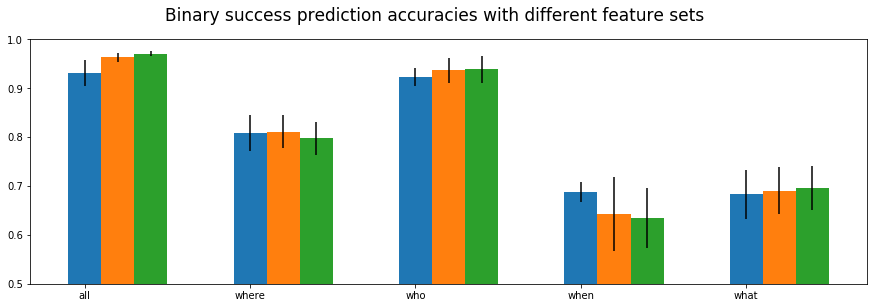

In [94]:
f, ax = plt.subplots(1,1,figsize=(15,4.5))

ax.bar(np.arange(len(names)),      results,   yerr = errors,   width = 0.2, label = 'all features')
ax.bar(np.arange(len(names))+0.2,  resultsS,  yerr = errorsS,  width = 0.2, label = 'top predictive, correlated')
ax.bar(np.arange(len(names))+0.4,  resultsSc, yerr = errorsSc, width = 0.2, label = 'top predictive, uncorrelated')
ax.set_ylim([0.5,1.0])

#ax.bar(namesSc+0.8, results2Sc, yerr = errors2Sc, width = 0.4)
ax.set_xticklabels(np.arange(len(names))+0.2)
ax.set_xticklabels([''] + list(names))
plt.suptitle('Binary success prediction accuracies with different feature sets', fontsize = 17)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/binarypred.png')
print names

# Save data

In [136]:
venues_locations = pd.read_csv('../../ProcessedData/london/venues_info/venues_ward_full.dat', sep = '\t', index_col = 0)

venues_locations.head()



,lng,lat,ward,lng0,lat0,lng1,lat1,length,area
venue,,,,,,,,,
4ed012c26c2510ace08f6196,-0.148227,51.506406,E05000649,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259
5131bfc3e4b021182eb750c3,-0.116914,51.540017,E05000368,-0.126362,51.530726,-0.110892,51.548216,0.057344,0.000147
54075d1f498e92eeef450c56,-0.134685,51.513940,E05000649,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259
5214b8fb11d2f8576bfde883,-0.097689,51.373167,E05000153,-0.107011,51.362173,-0.063469,51.382757,0.130389,0.000487
5260ef75498eda1e8cbc86b2,-0.117076,51.518833,E05000138,-0.130472,51.512652,-0.105350,51.525517,0.073794,0.000155


In [179]:
features_save = features2.drop(columns = [c for c in features2.head().keys() if c not in features_most_pred_uncorr + ['LABEL_category']])
features_save.LABEL_category = features_save.LABEL_category.map(clustersids)
features_save = features_save.merge(venues_locations, right_index = True, left_index = True)
features_save = features_save.drop(columns = ["lng0", 'lng1', 'lat0', 'lat1', 'length', 'area', 'WHAT_venue_cat'])




In [19]:
venues_cats = {}
venues_subcats = {}

for ind, line in enumerate(open('../../ProcessedData/london/venues_info/venues_all_categories_times.dat')):
    
    field  = line.strip().split('\t')
    venue  = field[1]
    cat    = field[2]
    subcat = field[3]
    
    venues_cats[venue]    = cat
    venues_subcats[venue] = subcat

df_cat = pd.DataFrame(venues_cats.items())  
df_cat = df_cat.rename(columns = {0 : 'venue', 1 : 'WHAT_category'})
df_cat.index = df_cat['venue']
df_cat = df_cat.drop(columns = ['venue'])



df_subcat = pd.DataFrame(venues_subcats.items())  
df_subcat = df_subcat.rename(columns = {0 : 'venue', 1 : 'subcategory'})
df_subcat.index = df_subcat['venue']
df_subcat = df_subcat.drop(columns = ['venue'])

df_cats = df_cat.merge(df_subcat, right_index = True, left_index = True)

In [191]:
features_save = features_save.merge(df_cats, right_index = True, left_index = True).drop_duplicates()

In [177]:
venues_dist = {}
for cluster in clusters:
    clusters_venues[cluster] = []
    for ind, line in enumerate(open(outfolder + '/sorted_dist/sorted_dist_venues_in_' + cluster + '.dat')):
        venue, dist = line.strip().split('\t')
        venues_dist[venue] = dist
        
df_dist = pd.DataFrame(venues_dist.items())
df_dist = df_dist.rename(columns = {0 : 'venue', 1 : 'DTW_distance'})
df_dist.index = df_dist['venue']
df_dist = df_dist.drop(columns = ['venue'])
df_dist.head()

8183

In [198]:
features_save = features_save.merge(df_dist, right_index = True, left_index = True) 
features_save = features_save.drop(columns = ['WHAT_category_y', 'subcategory_y', 'DTW_distance_y'])
features_save = features_save.rename(columns = {'DTW_distance_x' : 'DTW_distance', 'WHAT_category_x' : 'WHAT_category',  'subcategory_x' : 'subcategory'})
features_save = features_save.dropna()

features_save.head()

len(features_save), len(features_save.keys())


(7951, 18)

In [200]:
features_save.to_csv('../../../../Dropbox/interns18_venues_success/data/sixshapes/feature_data.csv', sep = '\t')